In [ ]:
!pip install keras_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core as keras
import shutil
import tensorflow_datasets as tfds
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.datasets import mnist
#from tensorflow.keras.models import Sequential
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from keras.src.saving.saving_lib import save_weights_only
import itertools
cb = 0
old_acc = 0

Using PyTorch backend.


In [ ]:
decoded_imgs_dict = {}

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
#df_mse = pd.DataFrame(columns=['encoding_dim','train_loss', 'val_loss', 'activation'])
df_mse = pd.read_csv('/content/drive/MyDrive/df_mse.csv')
df_mse.drop(columns=['Unnamed: 0'], inplace=True)


hls = [2,4,8,16,32,64,94,128,187,256,374,512,784,195,205,210,225,275,int(784*.75), int(784*.65), int(784*.55),169,196,190, 184, 180, 176, 172]

#activations = ['relu', 'tanh']
activations = ['selu']

hyps = itertools.product(hls, activations)

In [ ]:
df_mse

,encoding_dim,train_loss,val_loss,activation
0,2,0.070862,0.079613,relu
1,2,0.086158,0.087455,tanh
2,4,0.056400,0.066264,relu
3,4,0.066772,0.072777,tanh
4,8,0.041749,0.051336,relu
...,...,...,...,...
79,190,0.004114,0.005075,selu
80,184,0.004235,0.005204,selu
81,180,0.004330,0.005343,selu
82,176,0.004468,0.005448,selu


In [ ]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/3.0.1.incompleteODD7LP/kmnist-train.tfrecord*...:   0%|          | …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/3.0.1.incompleteODD7LP/kmnist-test.tfrecord*...:   0%|          | 0…

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
x_train = []
for example in ds_train:
  x_train.append(example[0])

x_train = np.array(x_train, dtype=np.float32)
x_train = x_train/255

In [ ]:
x_test = []
for example in ds_test:
  x_test.append(example[0])

x_test = np.array(x_test, dtype=np.float32)
x_test = x_test/255

In [ ]:
y_train = []
for example in ds_train:
  y_train.append(example[1])
y_train = np.array(y_train)

In [ ]:

y_test = []
for example in ds_test:
  y_test.append(example[1])
y_test = np.array(y_test)

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., tf.cast(image, tf.float32) / 255.

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(60)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
x_train_noisy = x_train.copy()
x_test_noisy = x_test.copy()

rnd = np.random.random(x_train.shape)
i = rnd<=.10
x_train_noisy[i] = .25

rnd = np.random.random(x_test.shape)
i = rnd<=.10
x_test_noisy[i] = .25

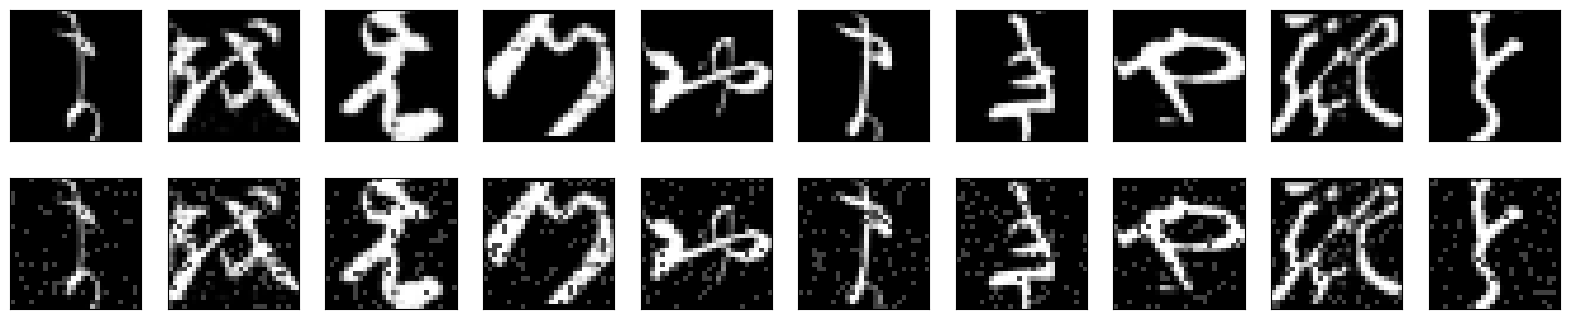

In [ ]:
#Check the noisifier, make sure it's working correctly!

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
off_set = np.random.randint(0, len(x_test)-11)
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noisified images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#I don't know why...but run this before making any other models.

from numpy.core.fromnumeric import reshape
import keras
from keras import layers

frac = .25
#encoding_dim = int(28*28*frac)
encoding_dim = 196
print(encoding_dim)

# This is our input image
input_img = keras.Input(shape=(28*28))
#do1 = layers.Dropout(.2)(input_img)
l_800 = layers.Dense(800, activation='relu')(input_img)
bn1 = layers.BatchNormalization()(l_800)
#do2 = layers.Dropout(.2)(bn1)
l_400 = layers.Dense(400, activation='relu')(bn1)
bn2 = layers.BatchNormalization()(l_400)
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(bn2)
# "decoded" is the lossy reconstruction of the input

encoded_input = keras.Input(shape=(encoding_dim,))
o_400 = layers.Dense(400, activation='relu')(encoded_input)
o_800 = layers.Dense(800, activation='relu')(o_400)

decoded = layers.Dense(784, activation='sigmoid')(o_800)

# This model maps an input to its reconstruction
encoder = keras.Model(input_img, encoded)
decoder = keras.Model(encoded_input, decoded)
encoding_layer = encoder(input_img)
autoencode = decoder(encoding_layer)
autoencoder = keras.Model(input_img, autoencode)



# Retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[4:6]
# Create the decoder model
#decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


196


In [ ]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
      self.dense = dense
      self.activation = keras.activations.get(activation)
      super().__init__(**kwargs)
  def build(self, batch_input_shape):
      self.biases = self.add_weight(name="bias",    initializer="zeros",shape=[self.dense.input_shape[-1]])
      super().build(batch_input_shape)
  def call(self, inputs):
      z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
      return self.activation(z + self.biases)

In [ ]:
encoding_dim = 64
dense_1 = keras.layers.Dense(800, activation="selu")
dense_2 = keras.layers.Dense(400, activation="selu")
encoded_layer = keras.layers.Dense(encoding_dim, activation="selu")
#tied_encoder
inputs = keras.Input(shape=(28*28))
l_en1 = dense_1(inputs)
l_en2 = dense_2(l_en1)
encoded = encoded_layer(l_en2)
encoder = keras.models.Model(inputs, encoded)

#tied_decoder
encoded_input = keras.Input(shape=(encoding_dim,))
l_dc0 = DenseTranspose(encoded_layer, activation = 'selu')(encoded_input)
l_dc1 = DenseTranspose(dense_2, activation="selu")(l_dc0)
l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
decoder = keras.models.Model(encoded_input, l_dc2)

encoding_layer = encoder(inputs)
autoencode = decoder(encoding_layer)
autoencoder = keras.Model(inputs, autoencode)

#autoencoder = keras.models.Model(inputs, l_dc2)
autoencoder.compile(optimizer='adam', loss="mean_squared_error", run_eagerly = True)
#autoencoder.compile(optimizer='adam', loss="binary_crossentropy", run_eagerly = True)

autoencoder.summary()

Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 784)]             0         
                                                                 
 model_84 (Functional)       (None, 64)                974064    
                                                                 
 model_85 (Functional)       (None, 784)               976048    
                                                                 
Total params: 976048 (3.72 MB)
Trainable params: 976048 (3.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras import backend as K

tf_2pi = tf.constant(tf.sqrt(2*np.pi), dtype=tf.float32)
sig = .75
@tf.function
def kernel(x, sigma=sig):
    return (1 / (tf_2pi * sigma)) * tf.exp((-(x * x) / (2 * sigma * sigma)))
@tf.function
def correntropy(y_true, y_pred):
    return -tf.math.reduce_mean(kernel(y_true - y_pred))

encoding_dim = 64
dense_1 = keras.layers.Dense(800, activation="selu")
dense_2 = keras.layers.Dense(400, activation="selu")
encoded_layer = keras.layers.Dense(encoding_dim, activation="selu")
#tied_encoder
inputs = keras.Input(shape=(28*28))
l_en1 = dense_1(inputs)
l_en2 = dense_2(l_en1)
encoded = encoded_layer(l_en2)
encoder_corr = keras.models.Model(inputs, encoded)

#tied_decoder
encoded_input = keras.Input(shape=(encoding_dim,))
l_dc0 = DenseTranspose(encoded_layer, activation = 'selu')(encoded_input)
l_dc1 = DenseTranspose(dense_2, activation="selu")(l_dc0)
l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
decoder_corr = keras.models.Model(encoded_input, l_dc2)

encoding_layer = encoder_corr(inputs)
autoencode = decoder_corr(encoding_layer)
autoencoder_corr = keras.Model(inputs, autoencode)

#autoencoder = keras.models.Model(inputs, l_dc2)
autoencoder_corr.compile(optimizer='adam', loss=correntropy, run_eagerly = True)
#autoencoder.compile(optimizer='adam', loss="binary_crossentropy", run_eagerly = True)

autoencoder_corr.summary()

Model: "model_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 784)]             0         
                                                                 
 model_81 (Functional)       (None, 64)                974064    
                                                                 
 model_82 (Functional)       (None, 784)               976048    
                                                                 
Total params: 976048 (3.72 MB)
Trainable params: 976048 (3.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary()

autoencoder.summary()

In [ ]:
checkpoint_filepath = "/tmp/mse_checkpoint-2"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

history = autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=2000,
                shuffle=True,
                callbacks=[checkpoint_callback],
                validation_data=(x_test, x_test))

autoencoder.load_weights(checkpoint_filepath)

In [ ]:
#For training an autoencoder on noisy data to see how well it works, using MSE!
checkpoint_filepath = "/tmp/mse_checkpoint-Noisy_MSE_64"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

history = autoencoder.fit(x_train_noisy,x_train,
                epochs=100,
                batch_size=2000,
                shuffle=True,
                callbacks=[checkpoint_callback],
                validation_data=(x_test_noisy, x_test))

autoencoder.load_weights(checkpoint_filepath)

Epoch 1/100
30/30 [==============================] - 2s 39ms/step - loss: 0.1493 - val_loss: 0.0853
Epoch 2/100
30/30 [==============================] - 1s 33ms/step - loss: 0.0643 - val_loss: 0.0548
Epoch 3/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0466 - val_loss: 0.0446
Epoch 4/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0384 - val_loss: 0.0384
Epoch 5/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0331 - val_loss: 0.0343
Epoch 6/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0296 - val_loss: 0.0334
Epoch 7/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0273 - val_loss: 0.0291
Epoch 8/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0254 - val_loss: 0.0278
Epoch 9/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0241 - val_loss: 0.0266
Epoch 10/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0234 - val_loss: 0.0261

In [ ]:
#For training an autoencoder on noisy data to see how well it works, using CORR!
checkpoint_filepath = "/tmp/mse_checkpoint-Noisy_CORR_64_p75"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

history = autoencoder_corr.fit(x_train_noisy,x_train,
                epochs=100,
                batch_size=2000,
                shuffle=True,
                callbacks=[checkpoint_callback],
                validation_data=(x_test_noisy, x_test))

autoencoder_corr.load_weights(checkpoint_filepath)

In [ ]:
enc = "MSE_NOISY_64"
trn_tst = (encoder.predict(x_train_noisy), encoder.predict(x_test))
encodings[enc] = trn_tst

313/313 [==============================] - 0s 1ms/step


In [ ]:
encodings.keys()

dict_keys([81, 100, 196, 225, 324, 49, 64, 'CORR_64'])

In [ ]:
decoded_imgs_dict.keys()

dict_keys([0.75, 0.8, 'mse', 0.6, 0.9, 1, 1.2, 1.5])

In [ ]:
encoded_corr = encoder_corr.predict(x_test_noisy)
decoded_imgs = decoder_corr.predict(encoded_corr)


313/313 [==============================] - 0s 1ms/step


In [ ]:
#sig = .75
decoded_imgs_dict[sig] = decoded_imgs

In [ ]:
#Test loop for determining the best encoding layer size.
from numpy.core.fromnumeric import reshape
import keras
from keras import layers
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5)
hyps = itertools.product(hls, activations)

for hyp in hyps:
  encoding_dim = hyp[0]
  activation = hyp[1]
  print(encoding_dim, activation)
  # This is our input image
  dense_1 = keras.layers.Dense(800, activation=activation)
  dense_2 = keras.layers.Dense(400, activation=activation)
  encoded_layer = keras.layers.Dense(encoding_dim, activation=activation)
  #tied_encoder
  inputs = keras.Input(shape=(28*28))
  l_en1 = dense_1(inputs)
  l_en2 = dense_2(l_en1)
  encoded = encoded_layer(l_en2)
  encoder = keras.models.Model(inputs, encoded)

  #tied_decoder
  encoded_input = keras.Input(shape=(encoding_dim,))
  l_dc0 = DenseTranspose(encoded_layer, activation = activation)(encoded_input)
  l_dc1 = DenseTranspose(dense_2, activation=activation)(l_dc0)
  l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
  decoder = keras.models.Model(encoded_input, l_dc2)

  encoding_layer = encoder(inputs)
  autoencode = decoder(encoding_layer)
  autoencoder = keras.Model(inputs, autoencode)

  #autoencoder = keras.models.Model(inputs, l_dc2)
  autoencoder.compile(optimizer='adam', loss="mean_squared_error", run_eagerly = True)

  #autoencoder.summary()
  history = autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=2000,
                shuffle=True,
                callbacks=[callback],
                validation_data=(x_test, x_test))
  new_row = pd.Series({'encoding_dim':encoding_dim, 'activation':activation, 'train_loss':np.min(history.history['loss']), 'val_loss':np.min(history.history['val_loss'])})
  df_mse = pd.concat([df_mse,new_row.to_frame().T],ignore_index=True)
  df_mse.to_csv('df_mse.csv')
  #!cp df_mse.csv /content/drive/MyDrive/df_mse.csv
  keras.backend.clear_session()

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = autoencoder.predict(x_test)

trn_encoded = encoder.predict(x_train)
tst_encoded = encoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


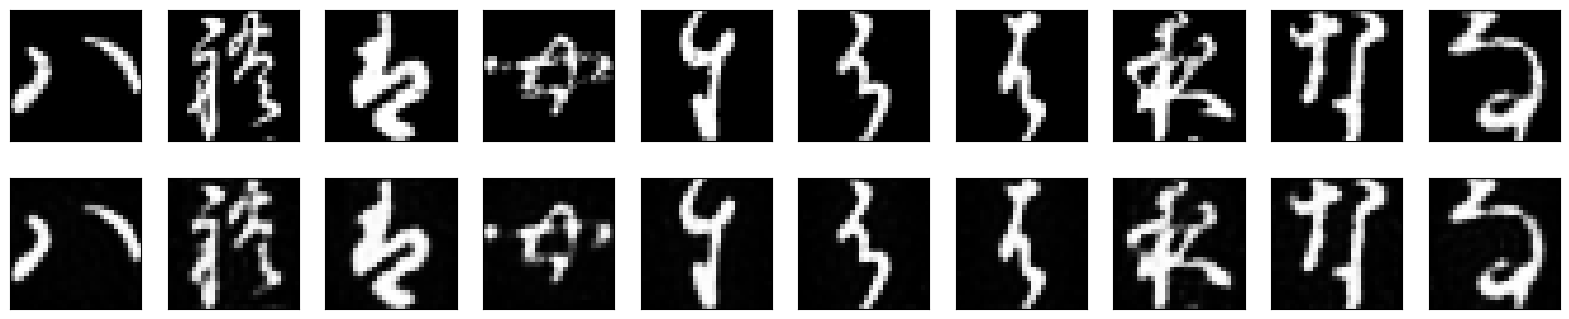

In [ ]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
off_set = np.random.randint(0, 10000-11)
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = autoencoder.predict(x_test)

#trn_encoded = encoder.predict(x_train)
#tst_encoded = encoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [ ]:
#decoded_imgs_dict['mse'] = decoded_imgs
decoded_imgs_dict.keys()

dict_keys([0.75, 0.8, 'mse', 0.6, 0.9, 1, 1.2, 1.5])

In [ ]:
# prompt: save decoded_imgs_dict with numpy

np.save('decoded_imgs_dict.npy', decoded_imgs_dict)
!cp decoded_imgs_dict.npy /content/drive/MyDrive/decoded_imgs_dict.npy


In [ ]:
# prompt: open decoded_imgs_dict.npy from google drive

import numpy as np
decoded_imgs_dict = np.load('/content/drive/MyDrive/decoded_imgs_dict.npy', allow_pickle=True).item()


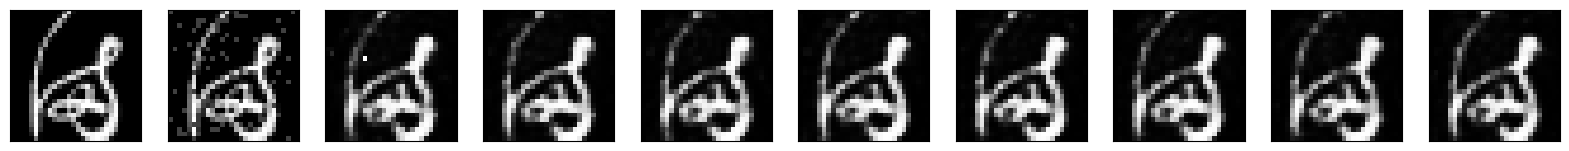

In [ ]:
import matplotlib.pyplot as plt

n = 7  # How many digits we will display
plt.figure(figsize=(20, 6))
off_set = np.random.randint(0, 10000-11)

ax = plt.subplot(1, 10, 1)
plt.imshow(x_test[off_set].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 10, 2)
plt.imshow(x_test_noisy[off_set].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

my_keys = [0.6, 0.75, 0.8,  0.9, 1, 1.2, 1.5 ,'mse']
i = 3
for j in my_keys:
  ax = plt.subplot(1, 10, i)
  plt.imshow(decoded_imgs_dict[j][off_set].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1

plt.show()

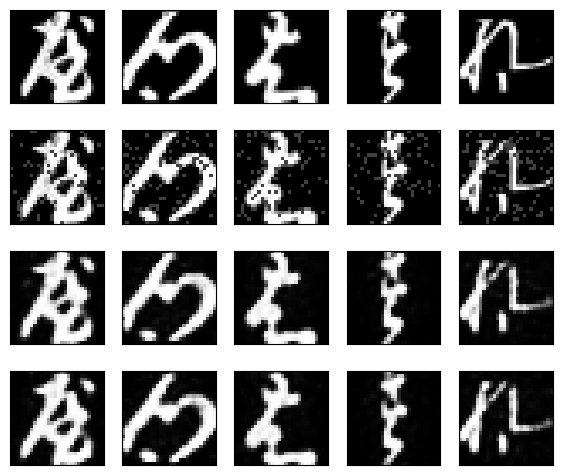

In [ ]:
import matplotlib.pyplot as plt

n = 5  # How many digits we will display
plt.figure(figsize=(7, 6))
off_set = np.random.randint(0, 10000-11)
for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noisy
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_dict[.75][i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(decoded_imgs_dict['mse'][i+off_set].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

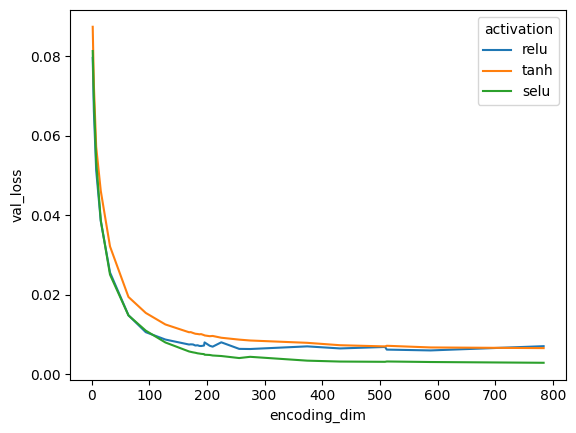

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x='encoding_dim', y='val_loss', data=df_mse, hue='activation')
plt.show()


In [ ]:
#enc_dim = [64,81,100,196,225,324]
enc_dim = [7*7,64]
mlp_size = [2048, 4096, 1024, 512]

In [ ]:
#encodings = {}
encodings = np.load('/content/drive/MyDrive/encodings.npy', allow_pickle=True).item()

for enc in enc_dim:
  checkpoint_filepath = "/tmp/mse_checkpoint_" + str(enc)
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
  )
  encoding_dim = enc
  activation = 'selu'
  print(encoding_dim, activation)
  # This is our input image
  dense_1 = keras.layers.Dense(800, activation=activation)
  dense_2 = keras.layers.Dense(400, activation=activation)
  encoded_layer = keras.layers.Dense(encoding_dim, activation=activation)
  #tied_encoder
  inputs = keras.Input(shape=(28*28))
  l_en1 = dense_1(inputs)
  l_en2 = dense_2(l_en1)
  encoded = encoded_layer(l_en2)
  encoder = keras.models.Model(inputs, encoded)

  #tied_decoder
  encoded_input = keras.Input(shape=(encoding_dim,))
  l_dc0 = DenseTranspose(encoded_layer, activation = activation)(encoded_input)
  l_dc1 = DenseTranspose(dense_2, activation=activation)(l_dc0)
  l_dc2 = DenseTranspose(dense_1, activation="sigmoid")(l_dc1)
  decoder = keras.models.Model(encoded_input, l_dc2)

  encoding_layer = encoder(inputs)
  autoencode = decoder(encoding_layer)
  autoencoder = keras.Model(inputs, autoencode)

  #autoencoder = keras.models.Model(inputs, l_dc2)
  autoencoder.compile(optimizer='adam', loss="mean_squared_error", run_eagerly = True)

  #autoencoder.summary()
  history = autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=2000,
                shuffle=True,
                callbacks=[checkpoint_callback],
                validation_data=(x_test, x_test))
  autoencoder.load_weights(checkpoint_filepath)
  trn_tst = (encoder.predict(x_train), encoder.predict(x_test))
  encodings[enc] = trn_tst
  #new_row = pd.Series({'encoding_dim':encoding_dim, 'activation':activation, 'train_loss':np.min(history.history['loss']), 'val_loss':np.min(history.history['val_loss'])})
  #df_mse = pd.concat([df_mse,new_row.to_frame().T],ignore_index=True)
  #df_mse.to_csv('df_mse.csv')
  #!cp df_mse.csv /content/drive/MyDrive/df_mse.csv
  keras.backend.clear_session()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

49 selu
Epoch 1/100


30/30 [==============================] - 7s 46ms/step - loss: 0.1426 - val_loss: 0.0790
Epoch 2/100
30/30 [==============================] - 1s 40ms/step - loss: 0.0622 - val_loss: 0.0539
Epoch 3/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0463 - val_loss: 0.0447
Epoch 4/100
30/30 [==============================] - 1s 42ms/step - loss: 0.0386 - val_loss: 0.0393
Epoch 5/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 6/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0303 - val_loss: 0.0327
Epoch 7/100
30/30 [==============================] - 1s 40ms/step - loss: 0.0289 - val_loss: 0.0314
Epoch 8/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0272 - val_loss: 0.0300
Epoch 9/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0262 - val_loss: 0.0292
Epoch 10/100
30/30 [==============================] - 1s 38ms/step - loss: 0.0257 - val_loss: 0.0286
Epoch 11/10

In [ ]:
# prompt: save encodings to a file using numpy

import numpy as np
np.save('encodings.npy', encodings)
!cp encodings.npy /content/drive/MyDrive/encodings.npy

In [ ]:
# prompt: load encodings.npy from google drive into a dictionary

encodings = np.load('/content/drive/MyDrive/encodings.npy', allow_pickle=True).item()


In [ ]:
encodings.keys()


dict_keys([81, 100, 196, 225, 324, 49, 64, 'CORR_64', 'MSE_NOISY_64'])

In [ ]:
#df_enc = pd.DataFrame(columns=['encoding_dim','mlp_size','layers','activation', 'train_acc', 'val_acc', 'CM'])
import pandas as pd
df_enc = pd.read_csv('/content/drive/MyDrive/df_enc.csv')
df_enc.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
#Once you have your encodings, use this training loop, as it includes the CM in pandas dataframe!
from sklearn.metrics import confusion_matrix
#enc_dim = [49,64,81,100,196,225,324]
enc_dim = ['CORR_64', 'MSE_NOISY_64']
mlp_size = [4096]
#act_func = ['relu', 'tanh', 'selu']
act_func = ['selu']
layers = [1]
hyps = itertools.product(enc_dim, mlp_size, act_func, layers)

for hyp in hyps:
  enc_size = hyp[0]
  mlp = hyp[1]
  act = hyp[2]
  size = hyp[3]
  print('encoding size:' + str(enc_size))
  print('Mlp Size:' + str(mlp))
  print('Activation Function:' + str(act))
  checkpoint_filepath = "/tmp/mse_checkpoint_"+ str(size) + str(enc_size) + str(mlp)+str(act)
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
  )
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=(64)))
  if size == 2:
    model.add(keras.layers.Dense(mlp*2, activation = act))
  model.add(keras.layers.Dense(mlp, activation = act))
  model.add(keras.layers.Dense(10))

  model.compile(
    optimizer=tf.keras.optimizers.Adam(.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),'accuracy'],
  )
  x_trn = encodings[enc_size][0]
  x_tst = encodings[enc_size][1]
  history = model.fit(
      x_trn, y_train,
      epochs=60,
      batch_size = 200,
      shuffle=True,
      callbacks=[checkpoint_callback],
      validation_data=(x_tst,y_test),
  )
  model.load_weights(checkpoint_filepath)
  y_pred = model.predict(encodings[enc_size][1])
  y_pred = tf.argmax(y_pred,axis=1)
  cm = confusion_matrix(y_test, y_pred)

  new_row = pd.Series({'encoding_dim':enc_size,'mlp_size':mlp,'layers':size ,'activation':act, 'train_acc':np.max(history.history['accuracy']), 'val_acc':np.max(history.history['val_accuracy']), 'CM':cm})
  df_enc = pd.concat([df_enc,new_row.to_frame().T],ignore_index=True)
  keras.backend.clear_session()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()



encoding size:CORR_64
Mlp Size:4096
Activation Function:selu
Epoch 1/60
300/300 [==============================] - 2s 3ms/step - loss: 5.0733 - sparse_categorical_accuracy: 0.6768 - accuracy: 0.6768 - val_loss: 1.4079 - val_sparse_categorical_accuracy: 0.6791 - val_accuracy: 0.6791
Epoch 2/60
300/300 [==============================] - 1s 3ms/step - loss: 0.5685 - sparse_categorical_accuracy: 0.8388 - accuracy: 0.8388 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.7727 - val_accuracy: 0.7727
Epoch 3/60
300/300 [==============================] - 1s 3ms/step - loss: 0.5465 - sparse_categorical_accuracy: 0.8632 - accuracy: 0.8632 - val_loss: 1.3038 - val_sparse_categorical_accuracy: 0.7387 - val_accuracy: 0.7387
Epoch 4/60
300/300 [==============================] - 1s 3ms/step - loss: 0.5127 - sparse_categorical_accuracy: 0.8813 - accuracy: 0.8813 - val_loss: 1.2098 - val_sparse_categorical_accuracy: 0.7634 - val_accuracy: 0.7634
Epoch 5/60
300/300 [==============================]

In [ ]:
# prompt: save df_enc to google drive

df_enc.to_csv('df_enc.csv')
!cp df_enc.csv /content/drive/MyDrive/df_enc.csv


In [ ]:
import pandas as pd

In [ ]:
# prompt: open df_enc.csv as a pandas datafram from google drive

import pandas as pd
df_enc = pd.read_csv('/content/drive/MyDrive/df_enc.csv')
df_enc.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df_enc

,encoding_dim,mlp_size,activation,train_acc,val_acc,CM,layers
0,64,2048,relu,0.972650,0.8882,[[905 2 1 1 22 3 4 32 28 2]\n [...,1
1,64,2048,relu,0.981200,0.8999,[[956 1 2 0 20 3 0 9 8 1]\n [...,2
2,64,2048,tanh,0.915883,0.8381,[[763 1 3 10 27 71 4 36 69 16]\n [...,1
3,64,2048,tanh,0.101950,0.1000,[[ 0 0 0 0 0 0 0 0 1000...,2
4,64,2048,selu,0.984667,0.9137,[[973 2 1 1 14 0 2 4 3 0]\n [...,1
...,...,...,...,...,...,...,...
153,64,4096,selu,0.969950,0.9057,[[889 12 1 0 35 33 0 22 8 0]\n [...,2
154,64,8192,selu,0.986283,0.9218,[[790 2 1 0 82 58 12 27 28 0]\n [...,1
155,64,8192,selu,0.966600,0.9047,[[769 7 2 18 17 63 0 19 84 21]\n [...,2
156,CORR_64,4096,selu,0.983850,0.9185,[[900 0 1 2 18 4 1 25 49 0]\n [...,1
